## Assignment 1
By Jing Wang, Alexander Moshchev, Saarthak Kataria, Suchitra Nayak, Yiting Yuan


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.random_projection import SparseRandomProjection
from sklearn.model_selection import train_test_split
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from sklearn import metrics
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings('ignore') # works
#warnings.filterwarnings(action='once') #does not work

## Random projections

Based on the program developed in the lecture (SparseRandomProjections), analyze 2 databases of your choice (but not exactly the same digits data as in the lecture) using random projections. Study the accuracy (or a score of your choice that makes most sense for your data) as a function of the number of dimensions / features that
survived the random projection.  
  
Try to avoid a zick-zack curve below or around the baseline accuracy curve as your final result for both datasets. At least for one dataset the score is expected to be a smooth-ish curve as a function of the kept number of
features. Provide a take-home statement and explain every step. You may find that data embedded in Euclidian spaces (such as digits) may be more appropriate than data for which Euclidian distances are not excellent distance measures

In [2]:
def compare_SparseRandomProjection(data, target, dimension):
    
    #first get the train test split
    split = train_test_split(data, 
                             target, 
                             test_size = 0.2, 
                             random_state = 11
                             )
    (trainData, testData, trainTarget, testTarget) = split
    
    #calculate orignal accurcay with 10 times average.
    baseline = np.empty([10])
    for i in range(0,10):
        model = LinearSVC()
        model.fit(trainData, trainTarget)
        baseline[i] = metrics.accuracy_score(model.predict(testData), testTarget)
    baseline_avg = baseline[:].mean()
    
    #get 30 with logspace to avoid recalculate in high dim
    dims = np.int32(np.logspace(np.log10(2), np.log10(dimension), 20))

    #calculate each dim in dims use Sparse Random Projection with 25 rounds
    
    #run it in realizations 25
    realizations = 25
    accuracies =np.empty([realizations, dimension+1])
    average_acc = []
    # Loop over the projection sizes, k
    for dim in dims:
        
        # average over realizations
        for i in range(realizations):
            # Create random projection
            sp = SparseRandomProjection(n_components = dim)
            X = sp.fit_transform(trainData)
    
            # Train classifier of your choice on the sparse random projection
            model = LinearSVC()
            model.fit(X, trainTarget)
    
            # Evaluate model and update accuracies
            test = sp.transform(testData)
            accuracies[i,dim]=(metrics.accuracy_score(model.predict(test), testTarget))

        average_acc.append(accuracies[:,dim].mean())   

    #plot the result
    plt.figure()
    plt.xlabel("# of dimensions k")
    plt.ylabel("AVG Accuracy")
    plt.xlim([2, dims[-1]])
    plt.ylim([0, 1])

    # Plot baseline and random projection accuracies
    plt.plot(dims, [baseline_avg] * len(average_acc), 
             color = "r", 
             label = "Orignal dimenson Average ACC"
             )
    plt.plot(dims, average_acc, label = 'Average ACC')
    """    
    plt.plot([k] * len(average_acc), 
             np.linspace(0,1,len(average_acc)), 
             label = 'John. Lind. K =' + str(k) +'eps = 0.2'
             )
    """
    plt.legend()
    plt.show()

## Guidelines for Selecting an Appropriate Dataset:
1. Opt for a dataset characterized by high dimensionality, which minimally impacts computational resources due to a manageable number of instances.
2. Ensure that all features within the dataset are represented using a uniform data type for consistency and simplicity in processing.
3. Utilize a Linear SVM (Support Vector Machine) model to effectively handle this dataset, ensuring satisfactory outcomes.

## Dataset from Openml with project name arcene

ARCENE's task is to distinguish cancer versus normal patterns from mass-spectrometric data. This is a two-class classification problem with continuous input variables.

It has 10001 features with 200 instances and 2 classes.

Source: UCI

linke : https://www.openml.org/search?type=data&sort=qualities.NumberOfFeatures&status=active&id=1458


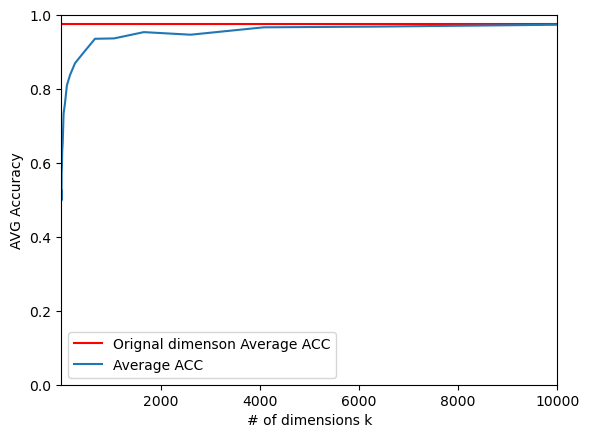

In the Arcene (samples = 400) Professors Johnson and Lindenstrauss say: k >= 5135 with eps = 0.1


In [3]:
from sklearn.datasets import fetch_openml
arcene = fetch_openml(name='arcene')
compare_SparseRandomProjection(arcene.data, arcene.target, 10001)

# for samples 400 as arcene
print ("In the Arcene (samples = 400) Professors Johnson and Lindenstrauss say: k >=", 
       johnson_lindenstrauss_min_dim(400, eps=0.1), "with eps = 0.1"
       )

**Explain every step:**
We start by loading the "arcene" dataset from openml and splitting it
into training and test sets. 

For the ARCENE dataset, the dims will be calculated as 20 logarithmically spaced values between 2 and 10,001, since the original data dimensionality is 10,001.

We then use the johnson_lindenstrauss_min_dim function from scikit-learn to
determine the minimum number of dimensions needed to preserve the pairwise
distances between points in the dataset with a certain epsilon (0.1 in this case).
Introducing the sample size in the Johnson Lindenstrauss lemma, it turns out that our
minimum number of dimension k >= 5135

Next, we train a Linear Support Vector Machine (SVM) model on the original data and
compute the accuracy of the model on the test set as the baseline accuracy. Then,
we apply sparse random projections to the training data for a range of projection
dimensions to reduce the dimensionality and train a Linear SVM model on this reduced data to compute the
accuracy on the test set. It does this for 25 rounds to get an average accuracy for each reduced dimensionality.
The average eliminates individual differences to reduce zick-zack lines.

The accuracies obtained for each projection dimension are plotted against the
number of dimensions in the projection. We decided to plot the accuracy for a span
of dimensions starting from 2 until the "full" dimension of 10001 to be able to better
visualize that we don't see any zick-zack lines.

## Dataset from Openml with project name Mnist 784

The MNIST database of handwritten digits with 784 features,
It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field.

It has 784 features with 70000 instances and 10 classes.  We use the instances reduced in 10000 to  save the compute resource.

https://www.openml.org/search?type=data&sort=runs&id=554&status=active

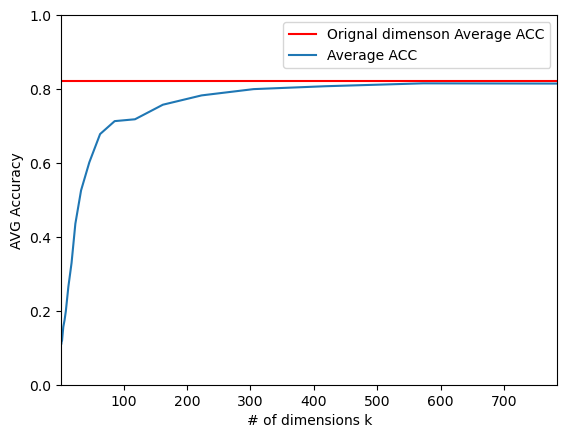

In the Mnist (sample = 1000) Professors Johnson and Lindenstrauss say: k >= 5920 with eps = 0.1


In [6]:
from sklearn.datasets import fetch_openml
import numpy as np

# Load mnist 784
mnist = fetch_openml('mnist_784', version=1, as_frame=True)

# get the data and target
raw_data = mnist.data
raw_target = mnist.target

# prepare a empty index list
indices = []

# for each class find 100 instances
for i in range(10):  
    class_indices = np.where(raw_target == str(i))[0]
    if len(class_indices) >= 100:
        selected_indices = np.random.choice(class_indices, 100, replace=False)
        indices.extend(selected_indices)


#use indices reduce the instances from 70000 to 1000
mnist_data= raw_data.iloc[indices]
mnist_target = raw_target.iloc[indices]
compare_SparseRandomProjection(mnist_data, mnist_target ,784)

# for samples 1000 as mnist
print ("In the Mnist (sample = 1000) Professors Johnson and Lindenstrauss say: k >=", 
       johnson_lindenstrauss_min_dim(1000, eps=0.1), "with eps = 0.1"
       )

**Explain every step:**
We start by loading the "fMnist 784" dataset from openml and splitting it
into training and test sets. 

Subset Selection reduce instances:
 . Initialize an empty list to keep track of selected indices.
 . Loop over each digit class (0 through 9).
 . For each class, find indices where the class matches the current digit.
 . Randomly select 100 indices from this set to ensure class balance.
 . Extend the main list of indices with these selected indices.

We then use the johnson_lindenstrauss_min_dim function from scikit-learn to
determine the minimum number of dimensions needed to preserve the pairwise
distances between points in the dataset with a certain epsilon (0.1 in this case).
Introducing the sample size in the Johnson Lindenstrauss lemma, it turns out that our
minimum number of dimension k >= 5920

Next, we train a Linear Support Vector Machine (SVM) model on the original data and
compute the accuracy of the model on the test set as the baseline accuracy. Then,
we apply sparse random projections to the training data for a range of projection
dimensions to reduce the dimensionality and train a Linear SVM model on this reduced data to compute the
accuracy on the test set.

The accuracies obtained for each projection dimension are plotted against the
number of dimensions in the projection. We decided to plot the accuracy for a span
of dimensions starting from 2 until the "full" dimension of 784 to be able to better
visualize that we don't see any zick-zack lines.

Our main takeaway considering both datasets is that even if the Lemma suggests a k way
higher than our d, we may still be able to obtain good results.

**Take Home Message:**
Two datasets’ analyses illustrate the concept of dimensionality reduction and its impact on classification accuracy.  
   
The ARCENE dataset, with its 10,001 features for 400 instances, is a challenge in high-dimensional data analysis aimed at cancer detection. The Johnson-Lindenstrauss lemma, with an epsilon of 0.1, suggests a high dimensionality of 5135 to preserve pairwise distances.  

In the case of the MNIST dataset, which has 784 dimensions and 1000 intances by default, the lemma recommends a projection into 5920 dimensions to achieve a similar level of distance preservation.   
  
JL lemma works for the arcene and doenst work for mnist because JL lemma, projecting 400 samples without too much distortion will require at least several thousands dimensions, irrespective of the number of features of the original dataset.  

Hence using random projections on the digits dataset which only has 784 features in the input space does not make sense: it does not allow for dimensionality reduction in this case.

This is essential for reducing computational costs and improving the efficiency of machine learning models while maintaining robust performance.